In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error

In [2]:
# Susceptible equation
def dS_dt(S, I, R_t, t_inf):
    return -(R_t / t_inf) * I * S


# Exposed equation
def dE_dt(S, E, I, R_t, t_inf, t_inc):
    return (R_t / t_inf) * I * S - (E / t_inc)


# Infected equation
def dI_dt(I, E, t_inc, t_inf):
    return (E / t_inc) - (I / t_inf)


# Hospialized equation
def dH_dt(I, C, H, t_inf, t_hosp, t_crit, m_a, f_a):
    return ((1 - m_a) * (I / t_inf)) + ((1 - f_a) * C / t_crit) - (H / t_hosp)


# Critical equation
def dC_dt(H, C, t_hosp, t_crit, c_a):
    return (c_a * H / t_hosp) - (C / t_crit)


# Recovered equation
def dR_dt(I, H, t_inf, t_hosp, m_a, c_a):
    return (m_a * I / t_inf) + (1 - c_a) * (H / t_hosp)


# Deaths equation
def dD_dt(C, t_crit, f_a):
    return f_a * C / t_crit


def SEIR_HCD_model(t, y, R_t, t_inc=2.9, t_inf=5.2, t_hosp=4, t_crit=14, m_a=0.8, c_a=0.1, f_a=0.3):
    """

    :param t: Time step for solve_ivp
    :param y: Previous solution or initial values
    :param R_t: Reproduction number
    :param t_inc: Average incubation period. Default 5.2 days
    :param t_inf: Average infectious period. Default 2.9 days
    :param t_hosp: Average time a patient is in hospital before either recovering or becoming critical. Default 4 days
    :param t_crit: Average time a patient is in a critical state (either recover or die). Default 14 days
    :param m_a: Fraction of infections that are asymptomatic or mild. Default 0.8
    :param c_a: Fraction of severe cases that turn critical. Default 0.1
    :param f_a: Fraction of critical cases that are fatal. Default 0.3
    :return:
    """
    if callable(R_t):
        reprod = R_t(t)
    else:
        reprod = R_t
        
    S, E, I, R, H, C, D = y
    
    S_out = dS_dt(S, I, reprod, t_inf)
    E_out = dE_dt(S, E, I, reprod, t_inf, t_inc)
    I_out = dI_dt(I, E, t_inc, t_inf)
    R_out = dR_dt(I, H, t_inf, t_hosp, m_a, c_a)
    H_out = dH_dt(I, C, H, t_inf, t_hosp, t_crit, m_a, f_a)
    C_out = dC_dt(H, C, t_hosp, t_crit, c_a)
    D_out = dD_dt(C, t_crit, f_a)
    return [S_out, E_out, I_out, R_out, H_out, C_out, D_out]

In [3]:
def plot_model(solution, title='SEIR+HCD model'):
    sus, exp, inf, rec, hosp, crit, death = solution.y
    
    cases = inf + rec + hosp + crit + death

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    fig.suptitle(title)
    
    ax1.plot(sus, 'tab:blue', label='Susceptible');
    ax1.plot(exp, 'tab:orange', label='Exposed');
    ax1.plot(inf, 'tab:red', label='Infected');
    ax1.plot(rec, 'tab:green', label='Recovered');
    ax1.plot(hosp, 'tab:purple', label='Hospitalised');
    ax1.plot(crit, 'tab:brown', label='Critical');
    ax1.plot(death, 'tab:cyan', label='Deceased');
    
    ax1.set_xlabel("Days", fontsize=10);
    ax1.set_ylabel("Fraction of population", fontsize=10);
    ax1.legend(loc='best');
    
    ax2.plot(cases, 'tab:red', label='Cases');    
    ax2.set_xlabel("Days", fontsize=10);
    ax2.set_ylabel("Fraction of population (Cases)", fontsize=10, color='tab:red');
    
    ax3 = ax2.twinx()
    ax3.plot(death, 'tab:cyan', label='Deceased');    
    ax3.set_xlabel("Days", fontsize=10);
    ax3.set_ylabel("Fraction of population (Fatalities)", fontsize=10, color='tab:cyan');

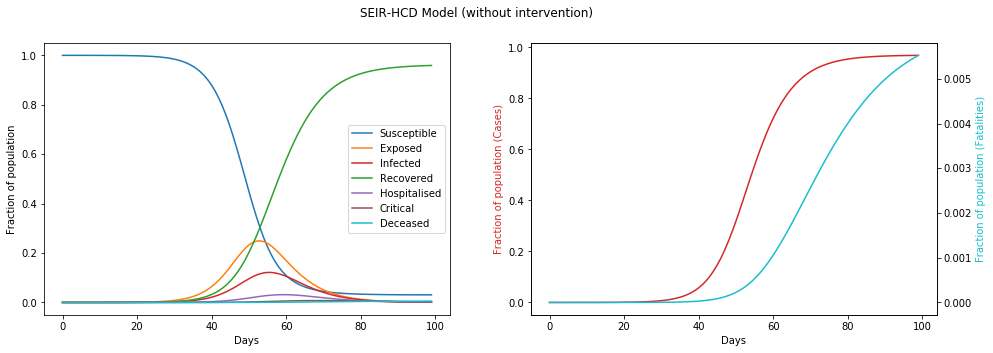

In [4]:
N = 100000  # Population size
n_infected = 1
max_days = 100

# State at time = 0 for SEIR_HCD model
# The numbers correspond to the number of people in each of the SEIRHCD compartments
initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0, 0, 0, 0]

R_0 = 3.6
t_inc = 5.6
t_inf = 2.9
t_hosp = 4
t_crit = 14
m_a = 0.8
c_a = 0.1
f_a = 0.3

args = (R_0, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)

sol = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(max_days))

plot_model(sol, 'SEIR-HCD Model (without intervention)')

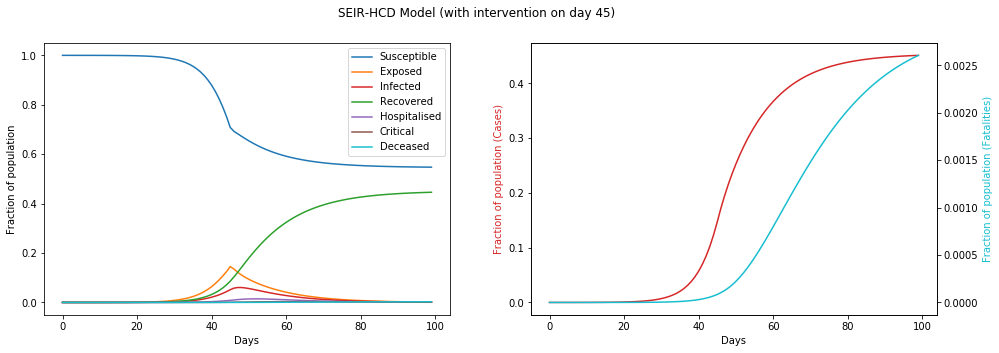

In [5]:
R_0 = 3.6 # reproduction number without intervention
R_t = 0.7  # reproduction number after intervention
intervention_day = 45

def time_varying_reproduction(t):
    if t > intervention_day:
        return R_t
    else:
        return R_0
    
args = (time_varying_reproduction, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)

sol2 = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(max_days))

plot_model(sol2, f'SEIR-HCD Model (with intervention on day {intervention_day})')

In [6]:
DATE_BORDER = '2020-04-08'

data_path = Path('input/covid19-global-forecasting-week-3/')

train = pd.read_csv(data_path / 'train.csv', parse_dates=['Date'])
test = pd.read_csv(data_path /'test.csv', parse_dates=['Date'])
submission = pd.read_csv(data_path /'submission.csv', index_col=['ForecastId'])

# Load the population data into lookup dicts
pop_info = pd.read_csv('input/covid19-population-data/population_data.csv')
country_pop = pop_info.query('Type == "Country/Region"')
province_pop = pop_info.query('Type == "Province/State"')
country_lookup = dict(zip(country_pop['Name'], country_pop['Population']))
province_lookup = dict(zip(province_pop['Name'], province_pop['Population']))

# Fix the Georgia State/Country confusion - probably a better was of doing this :)
train['Province_State'] = train['Province_State'].replace('Georgia', 'Georgia (State)')
test['Province_State'] = test['Province_State'].replace('Georgia', 'Georgia (State)')
province_lookup['Georgia (State)'] = province_lookup['Georgia']

train['Area'] = train['Province_State'].fillna(train['Country_Region'])
test['Area'] = test['Province_State'].fillna(test['Country_Region'])

# https://www.kaggle.com/c/covid19-global-forecasting-week-1/discussion/139172
train['ConfirmedCases'] = train.groupby('Area')['ConfirmedCases'].cummax()
train['Fatalities'] = train.groupby('Area')['Fatalities'].cummax()

# Remove the leaking data
train_full = train.copy()
valid = train[train['Date'] >= test['Date'].min()]
train = train[train['Date'] < test['Date'].min()]

# Split the test into public & private
test_public = test[test['Date'] <= DATE_BORDER]
test_private = test[test['Date'] > DATE_BORDER]

# Use a multi-index for easier slicing
train_full.set_index(['Area', 'Date'], inplace=True)
train.set_index(['Area', 'Date'], inplace=True)
valid.set_index(['Area', 'Date'], inplace=True)
test_public.set_index(['Area', 'Date'], inplace=True)
test_private.set_index(['Area', 'Date'], inplace=True)

submission['ConfirmedCases'] = 0
submission['Fatalities'] = 0


In [7]:
OPTIM_DAYS = 21  # Number of days to use for the optimisation evaluation
# Use a constant reproduction number
def eval_model_const(params, data, population, return_solution=False, forecast_days=0):
    R_0, t_hosp, t_crit, m, c, f = params
    N = population
    n_infected = data['ConfirmedCases'].iloc[0]
    max_days = len(data) + forecast_days
    initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0, 0, 0, 0]
    args = (R_0, 5.6, 2.9, t_hosp, t_crit, m, c, f)
               
    sol = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(0, max_days))
    
    sus, exp, inf, rec, hosp, crit, deaths = sol.y
    
    y_pred_cases = np.clip(inf + rec + hosp + crit + deaths, 0, np.inf) * population
    y_true_cases = data['ConfirmedCases'].values
    y_pred_fat = np.clip(deaths, 0, np.inf) * population
    y_true_fat = data['Fatalities'].values
    
    optim_days = min(OPTIM_DAYS, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    
    msle_final = np.mean([msle_cases, msle_fat])
    
    if return_solution:
        return msle_final, sol
    else:
        return msle_final

In [8]:
# Use a Hill decayed reproduction number
def eval_model_decay(params, data, population, return_solution=False, forecast_days=0):
    R_0, t_hosp, t_crit, m, c, f, k, L = params  
    N = population
    n_infected = data['ConfirmedCases'].iloc[0]
    max_days = len(data) + forecast_days
    
    # https://github.com/SwissTPH/openmalaria/wiki/ModelDecayFunctions   
    # Hill decay. Initial values: R_0=2.2, k=2, L=50
    def time_varying_reproduction(t): 
        return R_0 / (1 + (t/L)**k)
    
    initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0, 0, 0, 0]
    args = (time_varying_reproduction, 5.6, 2.9, t_hosp, t_crit, m, c, f)
            
    sol = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(0, max_days))
    
    sus, exp, inf, rec, hosp, crit, deaths = sol.y
    
    y_pred_cases = np.clip(inf + rec + hosp + crit + deaths, 0, np.inf) * population
    y_true_cases = data['ConfirmedCases'].values
    y_pred_fat = np.clip(deaths, 0, np.inf) * population
    y_true_fat = data['Fatalities'].values
    
    optim_days = min(OPTIM_DAYS, len(data))  # Days to optimise for
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted
    
    msle_cases = mean_squared_log_error(y_true_cases[-optim_days:], y_pred_cases[-optim_days:], weights)
    msle_fat = mean_squared_log_error(y_true_fat[-optim_days:], y_pred_fat[-optim_days:], weights)
    msle_final = np.mean([msle_cases, msle_fat])
    
    if return_solution:
        return msle_final, sol
    else:
        return msle_final

In [9]:
def use_last_value(train_data, valid_data, test_data):
    lv = train_data[['ConfirmedCases', 'Fatalities']].iloc[-1].values
    
    forecast_ids = test_data['ForecastId']
    submission.loc[forecast_ids, ['ConfirmedCases', 'Fatalities']] = lv
    
    if valid_data is not None:
        y_pred_valid = np.ones((len(valid_data), 2)) * lv.reshape(1, 2)
        y_true_valid = valid_data[['ConfirmedCases', 'Fatalities']]

        msle_cases = mean_squared_log_error(y_true_valid['ConfirmedCases'], y_pred_valid[:, 0])
        msle_fat = mean_squared_log_error(y_true_valid['Fatalities'], y_pred_valid[:, 1])
        msle_final = np.mean([msle_cases, msle_fat])

        return msle_final

In [10]:
def plot_model_results(y_pred, train_data, valid_data=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    
    ax1.set_title('Confirmed Cases')
    ax2.set_title('Fatalities')
    
    train_data['ConfirmedCases'].plot(label='Confirmed Cases (train)', color='g', ax=ax1)
    y_pred.loc[train_data.index, 'ConfirmedCases'].plot(label='Modeled Cases', color='r', ax=ax1)
    ax3 = y_pred['R'].plot(label='Reproduction number', color='c', linestyle='-', secondary_y=True, ax=ax1)
    ax3.set_ylabel("Reproduction number", fontsize=10, color='c');
        
    train_data['Fatalities'].plot(label='Fatalities (train)', color='g', ax=ax2)
    y_pred.loc[train_data.index, 'Fatalities'].plot(label='Modeled Fatalities', color='r', ax=ax2)
    
    if valid_data is not None:
        valid_data['ConfirmedCases'].plot(label='Confirmed Cases (valid)', color='g', linestyle=':', ax=ax1)
        valid_data['Fatalities'].plot(label='Fatalities (valid)', color='g', linestyle=':', ax=ax2)
        y_pred.loc[valid_data.index, 'ConfirmedCases'].plot(label='Modeled Cases (forecast)', color='r', linestyle=':', ax=ax1)
        y_pred.loc[valid_data.index, 'Fatalities'].plot(label='Modeled Fatalities (forecast)', color='r', linestyle=':', ax=ax2)
    else:
        y_pred.loc[:, 'ConfirmedCases'].plot(label='Modeled Cases (forecast)', color='r', linestyle=':', ax=ax1)
        y_pred.loc[:, 'Fatalities'].plot(label='Modeled Fatalities (forecast)', color='r', linestyle=':', ax=ax2)
        
    ax1.legend(loc='best')
    

In [11]:
def fit_model_public(area_name, 
                     initial_guess=[3.6, 4, 14, 0.8, 0.1, 0.3, 2, 50],
                     bounds=((1, 20), # R bounds
                             (0.5, 10), (2, 20), # transition time param bounds
                             (0.5, 1), (0, 1), (0, 1), (1, 5), (1, 100)), # fraction time param bounds
                     make_plot=True):
        
    train_data = train.loc[area_name].query('ConfirmedCases > 0')
    valid_data = valid.loc[area_name]
    test_data = test_public.loc[area_name]  
    
    try:
        population = province_lookup[area_name]
    except KeyError:
        population = country_lookup[area_name]
        
    cases_per_million = train_data['ConfirmedCases'].max() * 10**6 / population
    n_infected = train_data['ConfirmedCases'].iloc[0]
        
    if cases_per_million < 1:
        return use_last_value(train_data, valid_data, test_data)
                
    res_const = minimize(eval_model_const, initial_guess[:-2], bounds=bounds[:-2],
                         args=(train_data, population, False),
                         method='L-BFGS-B')
    
    res_decay = minimize(eval_model_decay, initial_guess, bounds=bounds,
                         args=(train_data, population, False),
                         method='L-BFGS-B')
    
    dates_all = train_data.index.append(test_data.index)
    dates_val = train_data.index.append(valid_data.index)
    
    
    # If using a constant R number is better, use that model
    if res_const.fun < res_decay.fun:
        msle, sol = eval_model_const(res_const.x, train_data, population, True, len(test_data))
        res = res_const
        R_t = pd.Series([res_const.x[0]] * len(dates_val), dates_val)
    else:
        msle, sol = eval_model_decay(res_decay.x, train_data, population, True, len(test_data))
        res = res_decay
        
        # Calculate the R_t values
        t = np.arange(len(dates_val))
        R_0, t_hosp, t_crit, m, c, f, k, L = res.x  
        R_t = pd.Series(R_0 / (1 + (t/L)**k), dates_val)
        
    sus, exp, inf, rec, hosp, crit, deaths = sol.y
    
    y_pred = pd.DataFrame({
        'ConfirmedCases': np.clip(inf + rec + hosp + crit + deaths, 0, np.inf) * population,
        'Fatalities': np.clip(deaths, 0, np.inf) * population,
        'R': R_t,
    }, index=dates_all)
    
    y_pred_valid = y_pred.iloc[len(train_data): len(train_data)+len(valid_data)]
    y_pred_test = y_pred.iloc[len(train_data):]
    y_true_valid = valid_data[['ConfirmedCases', 'Fatalities']]
        
    valid_msle_cases = mean_squared_log_error(y_true_valid['ConfirmedCases'], y_pred_valid['ConfirmedCases'])
    valid_msle_fat = mean_squared_log_error(y_true_valid['Fatalities'], y_pred_valid['Fatalities'])
    valid_msle = np.mean([valid_msle_cases, valid_msle_fat])
    
    if make_plot:
        print(f'Validation MSLE: {valid_msle:0.5f}')
        print(f'R: {res.x[0]:0.3f}, t_hosp: {res.x[1]:0.3f}, t_crit: {res.x[2]:0.3f}, '
              f'm: {res.x[3]:0.3f}, c: {res.x[4]:0.3f}, f: {res.x[5]:0.3f}')
        plot_model_results(y_pred, train_data, valid_data)
        
    # Put the forecast in the submission
    forecast_ids = test_data['ForecastId']
    submission.loc[forecast_ids, ['ConfirmedCases', 'Fatalities']] = y_pred_test[['ConfirmedCases', 'Fatalities']].values
    
    return valid_msle


In [12]:
# Fit a model on the full dataset (i.e. no validation)
def fit_model_private(area_name, 
                      initial_guess=[3.6, 4, 14, 0.8, 0.1, 0.3, 2, 50],
                      bounds=((1, 20), # R bounds
                              (0.5, 10), (2, 20), # transition time param bounds
                              (0.5, 1), (0, 1), (0, 1), (1, 5), (1, 100)), # fraction time param bounds
                      make_plot=True):
        
    train_data = train_full.loc[area_name].query('ConfirmedCases > 0')
    test_data = test_private.loc[area_name]
    
    try:
        population = province_lookup[area_name]
    except KeyError:
        population = country_lookup[area_name]
        
    cases_per_million = train_data['ConfirmedCases'].max() * 10**6 / population
    n_infected = train_data['ConfirmedCases'].iloc[0]
        
    if cases_per_million < 1:
        return use_last_value(train_data, None, test_data)
                
    res_const = minimize(eval_model_const, initial_guess[:-2], bounds=bounds[:-2],
                         args=(train_data, population, False),
                         method='L-BFGS-B')
    
    res_decay = minimize(eval_model_decay, initial_guess, bounds=bounds,
                         args=(train_data, population, False),
                         method='L-BFGS-B')
    
    dates_all = train_data.index.append(test_data.index)
    
    
    # If using a constant R number is better, use that model
    if res_const.fun < res_decay.fun:
        msle, sol = eval_model_const(res_const.x, train_data, population, True, len(test_data))
        res = res_const
        R_t = pd.Series([res_const.x[0]] * len(dates_all), dates_all)
    else:
        msle, sol = eval_model_decay(res_decay.x, train_data, population, True, len(test_data))
        res = res_decay
        
        # Calculate the R_t values
        t = np.arange(len(dates_all))
        R_0, t_hosp, t_crit, m, c, f, k, L = res.x  
        R_t = pd.Series(R_0 / (1 + (t/L)**k), dates_all)
        
    sus, exp, inf, rec, hosp, crit, deaths = sol.y
    
    y_pred = pd.DataFrame({
        'ConfirmedCases': np.clip(inf + rec + hosp + crit + deaths, 0, np.inf) * population,
        'Fatalities': np.clip(deaths, 0, np.inf) * population,
        'R': R_t,
    }, index=dates_all)
    
    y_pred_test = y_pred.iloc[len(train_data):]
    
    if make_plot:
        print(f'R: {res.x[0]:0.3f}, t_hosp: {res.x[1]:0.3f}, t_crit: {res.x[2]:0.3f}, '
              f'm: {res.x[3]:0.3f}, c: {res.x[4]:0.3f}, f: {res.x[5]:0.3f}')
        plot_model_results(y_pred, train_data)
        
    # Put the forecast in the submission
    forecast_ids = test_data['ForecastId']
    submission.loc[forecast_ids, ['ConfirmedCases', 'Fatalities']] = y_pred_test[['ConfirmedCases', 'Fatalities']].values
            

Validation MSLE: 0.10238
R: 3.848, t_hosp: 1.367, t_crit: 12.638, m: 0.502, c: 1.000, f: 0.792
R: 3.855, t_hosp: 0.548, t_crit: 2.000, m: 0.500, c: 0.313, f: 1.000


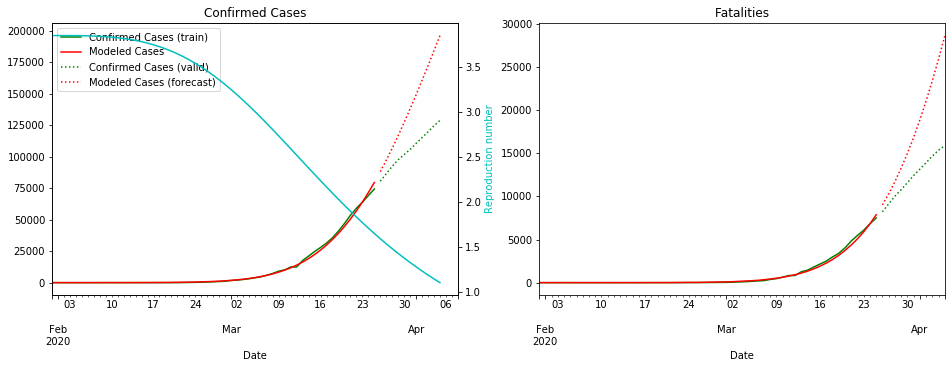

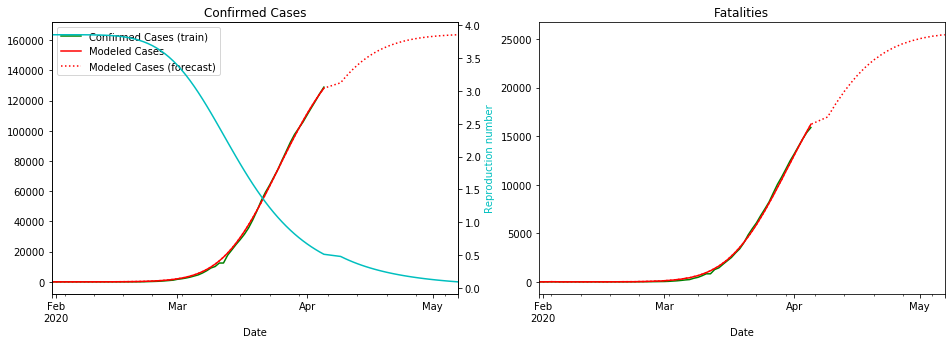

In [14]:
fit_model_public('Italy')
fit_model_private('Italy')

R: 20.000, t_hosp: 0.914, t_crit: 2.000, m: 0.662, c: 0.263, f: 1.000


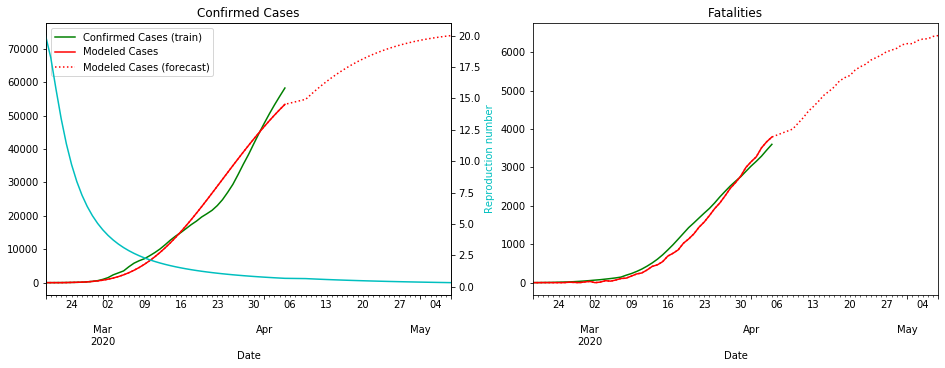

In [16]:
score = fit_model_private('Iran')

In [17]:
# Public Leaderboard
validation_scores = []

for c in tqdm(test_public.index.levels[0].values):
    try:
        score = fit_model_public(c, make_plot=False)
        validation_scores.append({'Country': c, 'MSLE': score})
        print(f'{score:0.5f} {c}')
    except IndexError as e:
        print(c, 'has no cases in train')
    except ValueError as e:
        print(c, e)

validation_scores = pd.DataFrame(validation_scores)
print(f'Mean validation score: {np.sqrt(validation_scores["MSLE"].mean()):0.5f}')

0.13210 Afghanistan
0.83023 Alabama
0.14510 Alaska
1.30955 Albania
0.07297 Alberta
0.11134 Algeria
0.45818 Andorra
0.73201 Angola
Anguilla has no cases in train
0.22490 Anhui
0.25678 Antigua and Barbuda
0.42688 Argentina
0.27892 Arizona
0.02734 Arkansas
1.65383 Armenia
0.07404 Aruba
1.48741 Australian Capital Territory
0.01765 Austria
0.09720 Azerbaijan
0.77491 Bahamas
0.91868 Bahrain
0.09729 Bangladesh
0.08825 Barbados
2.41440 Beijing
0.95300 Belarus
0.50154 Belgium
4.06389 Belize
0.18536 Benin
0.07024 Bermuda
0.14534 Bhutan
1.87298 Bolivia
0.02728 Bosnia and Herzegovina
Botswana has no cases in train
0.84680 Brazil
0.03516 British Columbia
British Virgin Islands has no cases in train
0.20227 Brunei
0.07121 Bulgaria
2.06601 Burkina Faso
Burma has no cases in train
Burundi has no cases in train
1.62145 Cabo Verde
0.10472 California
0.08082 Cambodia
0.22789 Cameroon
0.43003 Cayman Islands
0.08967 Central African Republic
0.18726 Chad
1.10633 Channel Islands
0.72270 Chile
1.89328 Chongqi